# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [23]:
import numpy as np
import functions as fn
import seismic_model as sm
import optimizer as opt
from matplotlib import pyplot as plt
from obspy.taup import TauPyModel
import importlib

***
#### Synthetic parameters
***

Original params:  [ 266.35092347   57.96081756 -163.18574684]


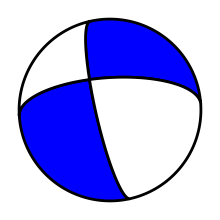

In [ ]:
np.random.seed(2024)
# np.random.seed(np.random.randint(0, 2024))

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

***
#### Hybrid inversion
***

In [ ]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
velocities = np.array([5.8000, 3.4600])

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)
Ao = inv_model.get_Ao()

# tune hyperparameters
config = opt.get_config()

# # initialize random hybrid search
# num_runs = 100
# starts = fn.random_params(num_runs)

# initialize systematic hybrid search
step_size = 45
starts = fn.systematic_params(step_size)
num_runs = len(starts)

# multi-start optimization
convergence_count = 0
best_params = []
best_misfits = []
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index+1}/{num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.get_convergence_rate():.0f}%')

Run 1/24
Run 11/24
Run 21/24
Convergence rate: 96%


Axis: T
Central: [46.99705665 32.10717867  6.5735907 ]
Half angle: 17.737647004120234 degrees
Search error: 2.7634327111292545 degrees


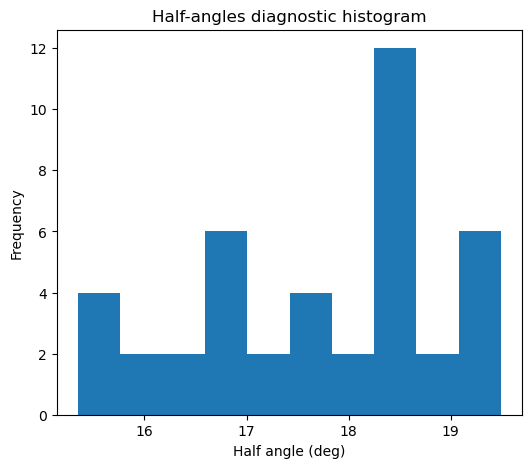

In [27]:
inv_model.filter_outliers()
central, half_angle, error, name = inv_model.optimal_parameterization()

print(f'Axis: {name}')
print(f'Central: {np.rad2deg(central)}')
print(f'Half angle: {np.rad2deg(half_angle)} degrees')
print(f'Search error: {np.rad2deg(error)} degrees')

inv_model.plot_half_angles(bins=10)

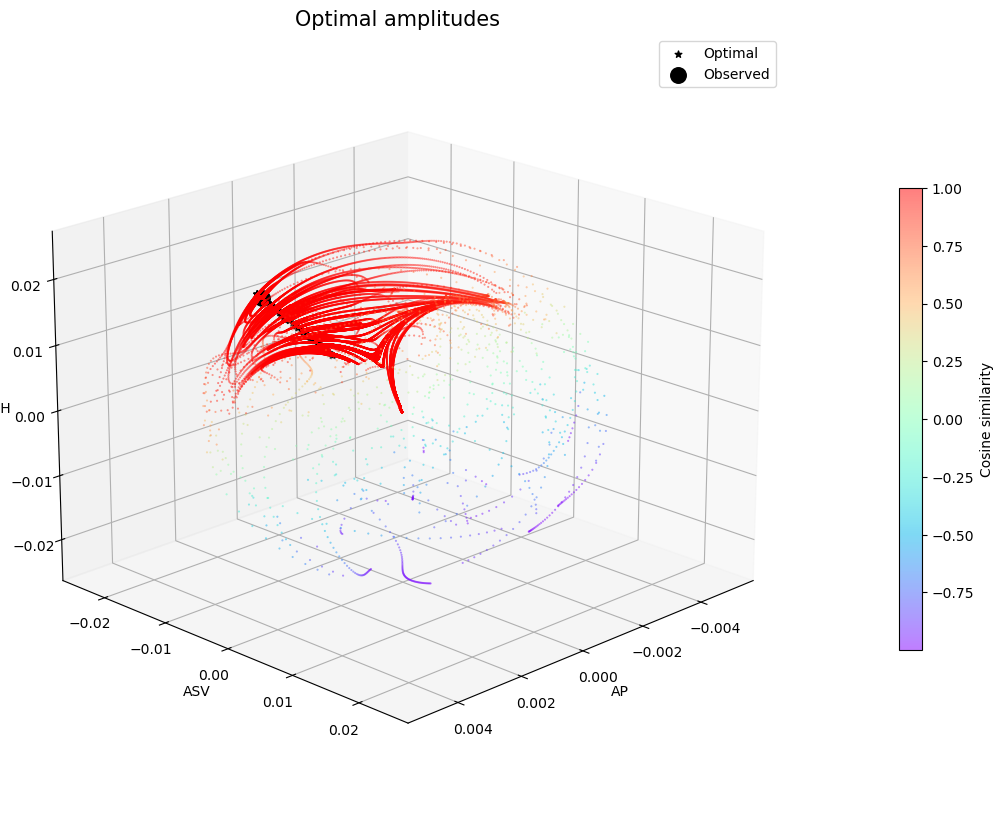

In [5]:
# amplitude plot
inv_model.plot_amplitudes(azim=45, elev=20, s=25, alpha=0.5, iterates=True)

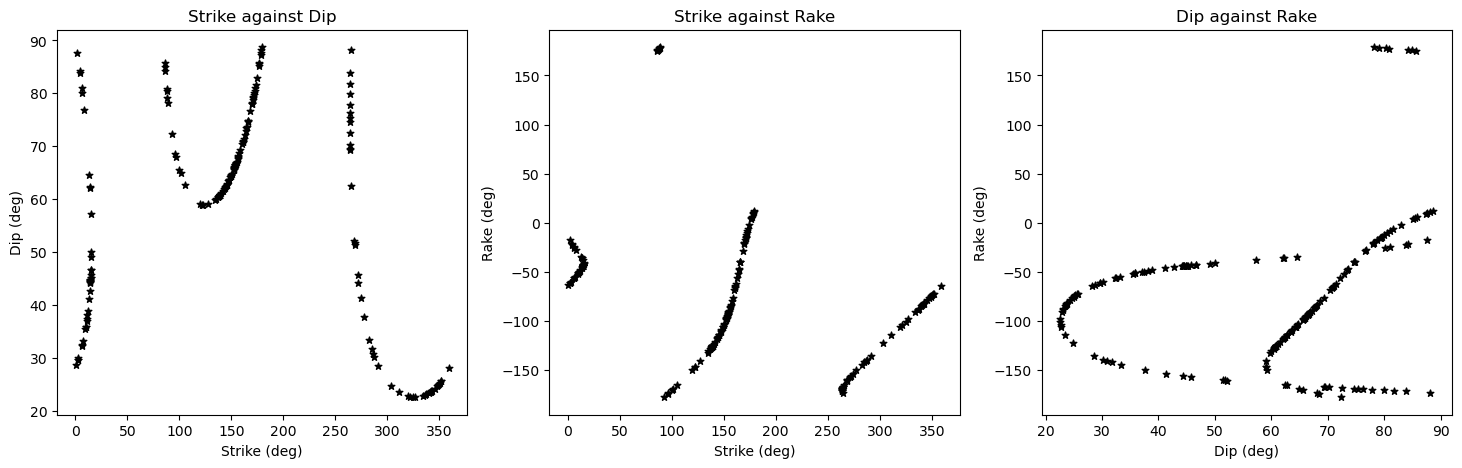

In [6]:
# iterate plot - sdr space
inv_model.plot_iterates_2D(s=25, optimal=True, index=2)
# inv_model.plot_iterates_2D(s=1, optimal=False, index=0)
# inv_model.plot_iterates_2D(s=1, optimal=False, index=1)

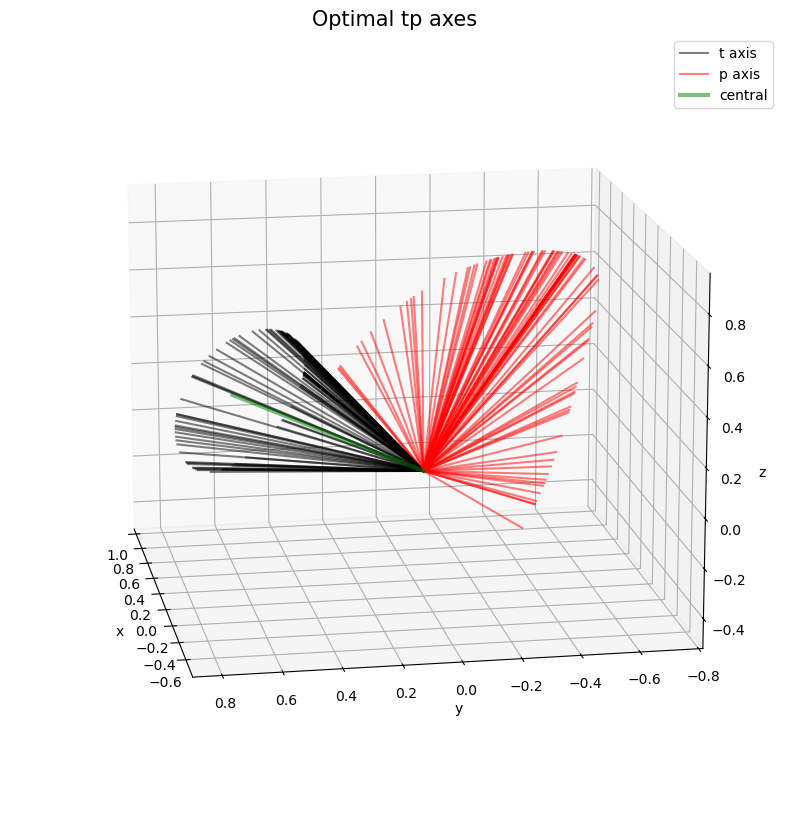

In [8]:
# optimal plot - tp space
inv_model.plot_tp_axes(azim=170, elev=15, half=True)

***
#### Uncertainty propagation
***

In [10]:
# something about the edge I saw: there's no need for simulation